# Environment

In [8]:
%qtconsole

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [7]:
import pulp
from pulp import lpSum
import networkx as nx

# Generate data

In [457]:
# make 600 customer locations and 120 engineers
random.seed(1)

n_nodes = 20

nodes = []

for _ in range(n_nodes):
    data=dict(
        X = rand() * 100,
        Y = rand() * 100,
    )
    nodes.append(data)

nodes = pd.DataFrame(nodes)

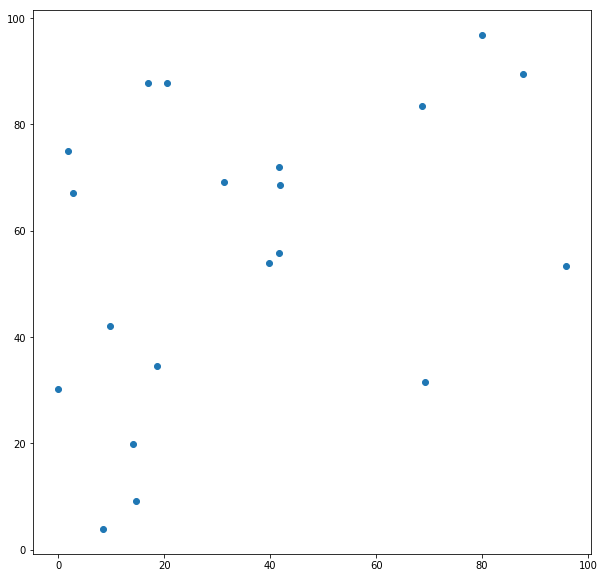

In [458]:
figsize(10,10)
scatter(nodes.X, nodes.Y, label='customers')

# Build model

## Data scructures

In [459]:
# use networkx to for graph analysis tools
# create graph where nodes are the indices of the node list
# nodes are fully connected but not directed
graph = nx.complete_graph(nodes.index)

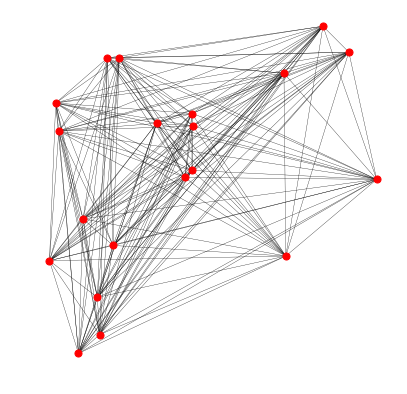

In [460]:
# draw this just for fun
figsize(5,5)
nx.draw(graph, pos={t.Index:(t.X,t.Y) for t in nodes.itertuples()}, node_size=50, width=.3)

In [461]:
# create edge table
# NB edges are indexed by the sorted tuple of their node indices, smallest to largest
edges = pd.DataFrame(index=[tuple(sorted(e)) for e in graph.edges()])

In [462]:
# create variables
edges['Variable'] = [pulp.LpVariable('{}_{}'.format(e[0],e[1]), cat='Binary') for e in edges.index]

In [463]:
# calculate distances
def calculate_distance(e):
    a,b = e
    a = nodes.loc[a]
    b = nodes.loc[b]
    return ((a.X - b.X)**2 + (a.Y - b.Y)**2)**0.5

edges['Distance'] = edges.index.map(calculate_distance)

## Build core integer programme

In [464]:
# instantiate model
mod = pulp.LpProblem()

In [465]:
# cost: distance travelled
mod += pulp.lpSum(edges.Variable * edges.Distance)

In [466]:
# constraint: each node has one edge in and one edge out (i.e. is visited only once)
for n in nodes.index:
    a = 0 
    for e in edges.index:
        if n in e:
            a += edges.Variable[e]
    mod += a == 2, 'one_visit_n{}'.format(n)

In [467]:
# solve the model
mod.solve()

1

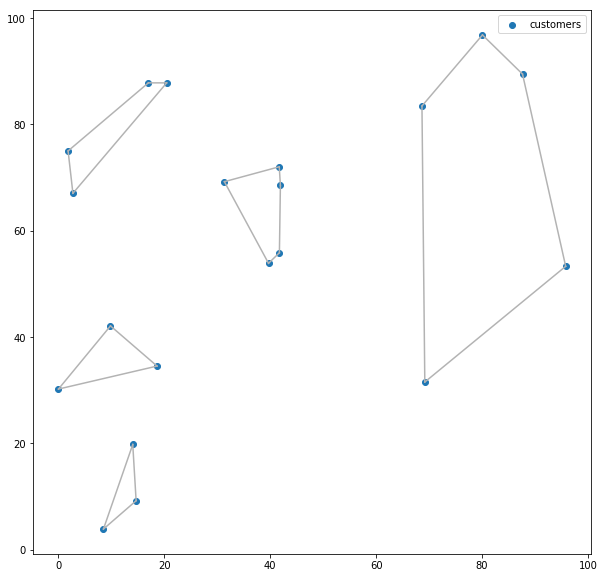

In [468]:
# visualise results
figsize(10,10)
scatter(nodes.X, nodes.Y, label='customers')

for e in edges.itertuples():
    if e.Variable.value() == 1:
        a,b = e.Index
        x = [nodes.X[a], nodes.X[b]]
        y = [nodes.Y[a], nodes.Y[b]]
        plot(x,y, color='0.7')

legend()

The problem is that there are subtours in the result. We need just one grande tour of all points. Unfortunately setting a constraint for every possible subtour would result in $2^n - 2$ constraints, so complexity quickly scales to infeasible numbers. The solution is to use lazy constraints. These are constraints that are created on an as needed basis to target the subtours that emerge in each solution iteration. 

## Add any necessary lazy constraints

In [469]:
# count subtour constraints added
n_subtours = 0

while True:
    # create graph of current solution
    g = graph.copy()
    
    # remove edges that weren't chosen
    for e in edges.itertuples():
        if e.Variable.value() != 1:
            g.remove_edge(*e.Index)
            
    # get list of subtour graphs
    subtours = list(nx.connected_component_subgraphs(g))
    
    # if no subtours (number of graphs is 1) then we have the solution
    if len(subtours) == 1:
        break
        
    # iterate over subtour graphs and build constraints to prevent them in the next solve
    for s in subtours:
        n_subtours += 1
        es = edges.loc[[tuple(sorted(e)) for e in s.edges]]
        mod += lpSum(es.Variable) == (s.number_of_nodes() - 1), 'lazy_subtour_constraint_{}'.format(n_subtours)
        
    # solve again
    r = mod.solve()
    
    # if solve failed then break
    if r != 1:
        break
        print('solve failed')

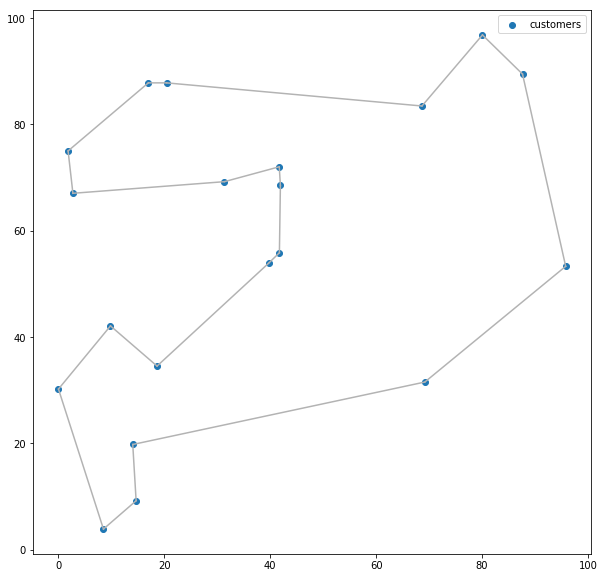

In [470]:
# visualise results
figsize(10,10)
scatter(nodes.X, nodes.Y, label='customers')

for e in edges.itertuples():
    if e.Variable.value() == 1:
        a,b = e.Index
        x = [nodes.X[a], nodes.X[b]]
        y = [nodes.Y[a], nodes.Y[b]]
        plot(x,y, color='0.7')

legend()